# Looking for Malicious Users Through Apache Log Analysis - Experiment 2

### Introduction
The inspiration for this project was to determine if/how malicous users could be identified by using machine learning tools to analyze Apache Web Server Logs. 

For this exercise, I use the freely-available Apache log samples available from NASA for one of their web servers from 1995. I'll start by identifying the kinds of data in the log file then isolate the activity on the site by user and perform [n-gram](https://en.wikipedia.org/wiki/N-gram) analysis to categorize new users as being 'typical' or 'a-typical'. The presumption is that 'a-typical' users would need to be analyzed further to determine if they were malicious. 

Some preliminary work will be assumed, so please review the [first experiment](ApacheNGram.ipynb) for additional details.

### Licence
This work is licensed under [CC BY 4.0](https://creativecommons.org/licenses/by/4.0/)
![CC BY 4.0](https://licensebuttons.net/l/by/3.0/88x31.png)

This license lets you distribute, remix, tweak, and build upon this work, even commercially, as long as you credit me, Robert Watkins, for the original creation. This is the most accommodating of licenses offered. Recommended for maximum dissemination and use of licensed materials.

### Data Dictionary
Using additional analysis not included in this notebook, I was able to come up with this data dictionary to describe the contents of the data file.

 | Column     | Description |
 |------------|:-----------:|
 | host       | The hostname or IP address making the request to the website |
 | logname    | not a populated field |
 | time       | integer version of unix timestamp |
 | method     | HTTP method for the call |
 | url        | path to the file being requested |
 | response   | HTTP response code for the call |
 | bytes      | Number of bytes returned for the request |
 | referer    | not a populated field |
 | useragent  | not a populated field |

---

### Prerequisites for this Python Notebook
 - python 3.x
 - python packages
   - pip3 install pandas
   - pip3 install scikit-learn
   - pip3 install matplotlib
   - pip3 install networkx
   - pip3 install hdbscan
   - pip3 install seaborn
 - jupyter notebook --debug > log.file 2>&1
 - mac users will need to install command-line tools for x-code
    xcode-select --install
 
### Sample data used for analysis
- http://indeedeng.github.io/imhotep/files/nasa_19950801.tsv (saved in 'rawData/nasa_19950801.tsv')
- http://indeedeng.github.io/imhotep/files/nasa_19950630.22-19950728.12.tsv.gz (Training Data)
- http://indeedeng.github.io/imhotep/files/nasa_19950731.22-19950831.22.tsv.gz (Testing Data)

### Import necessary libraries

In [40]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.mlab as mlab
from scipy.interpolate import griddata
import math
import hashlib 
import networkx as nx
import seaborn as sns
import scipy as sp
import itertools
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import DBSCAN
from sklearn.metrics.pairwise import pairwise_distances

# The Next Experiment

Ultimately, we are interested in determining if a pattern of usage for a new visitor looks 'typical' or 'a-typical'. In this case, we have existing usage that we will presume to be 'typical'. One common approach, which we'll be using, is the idea of 'clustering' our data. We need to group our usage of the system into usage where each usage of the system in the same group is close to each other. For a measure of 'closeness', we rely on being able to have a distance metric we can calculate.

In this experiment, we'll calculate clusters using the [Levenshtein Distance](https://en.wikipedia.org/wiki/Levenshtein_distance) also known as the 'edit distance' to compare a new path observed by a user to existing paths by other users. The Levenshtein Distance is called the 'edit distance' because it measures the number of edits it would take to change the first sequence to the second sequence. 

Rather than compare the full sequences of users' paths through the server to calculate the distance, we'll compare n-grams. It's not clear what choice of 'n' would be useful, so there will need to be some effort expended to choose a suitable 'n'.

We'll correspondingly have a point at which we determine where the minimum Levenshtein Distance classifies the new sequence as 'typical' or 'a-typical'.

This will result in having an optimized set of clusters and a corresponding configuration parameters to generate these clusters.

### The Primary Challenge
We don't have a good way to generate 'a-typcial' data in this case. So we're left at guessing a bit at what conditions will trigger an 'a-typical' categorization. Hopefully, using my current experience of how vulnerabiltiy-seeking tools and techniques work, I can come up with a sufficient variety of 'a-typical' calls to be able to test the model. 

Another challenge is that I'm not including any 'a-typical' data in my training. Any 'a-typical' behavior detected would be as a result of the user's path the system deviating sufficiently from normal navigation of the system and not from any other metadata.

### Define the Levenschtein Distance for ordered lists of requested urls

We are fortunate to have a well-established distance formula available to caluate the 'distance' between two sequences of urls to determine how similar they are. One slight drawback is that there is no common library to calculate the levenschtein distance for a general orderd list of elements.

The internet comes to the rescue to provide some tips on [rolling your own function](https://medium.com/@yash_agarwal2/soundex-and-levenshtein-distance-in-python-8b4b56542e9e) to perform this task.

In [2]:
def get_levenshtein_distance(path1, path2):
    """
    https://en.wikipedia.org/wiki/Levenshtein_distance
    :param path1:
    :param path2:
    :return:
    """
    matrix = [[0 for x in range(len(path2) + 1)] for x in range(len(path1) + 1)]

    for x in range(len(path1) + 1):
        matrix[x][0] = x
    for y in range(len(path2) + 1):
        matrix[0][y] = y

    for x in range(1, len(path1) + 1):
        for y in range(1, len(path2) + 1):
            if path1[x - 1] == path2[y - 1]:
                matrix[x][y] = min(
                    matrix[x - 1][y] + 1,
                    matrix[x - 1][y - 1],
                    matrix[x][y - 1] + 1
                )
            else:
                matrix[x][y] = min(
                    matrix[x - 1][y] + 1,
                    matrix[x - 1][y - 1] + 1,
                    matrix[x][y - 1] + 1
                )

    return matrix[len(path1)][len(path2)]

### Clustering Methodology
While the k-means clustering is seen as the de-facto standard for clustering, we won't be able to use it because it relies on the Euclidian space (using real numbers to identify points in the space). Our distance formula is strictly integer-based, so we need a [different](https://scikit-learn.org/stable/auto_examples/cluster/plot_cluster_comparison.html#sphx-glr-auto-examples-cluster-plot-cluster-comparison-py) [approach](https://www.datascience.com/blog/k-means-alternatives).

We'll be using [DBSCAN](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html) in the hopes that it provides a strong process to identify clusters from the noise and serves as a good method to distinquish 'a-typical' usage'.

Additionally, we'll generate n-grams from a month's worth of data as our training data. Then we will generate n-grams from a month's worth of testing data and calcualte the minimum Levenshtein Distance for each n-gram in the hopes that we can identify the threshold where the distance is large enough to be classified as 'a-typical'.

#### A few data formatting hoops
The implementation of DBSCAN library I'm using only accepts numbers to perform it's calculations, so each url in our n-gram will need to be replaced with a unique numeric identifier. To achieve that, I'll create a url id map and functions to translate the n-grams back and forth from url to id.


In [3]:
training_data_path = 'rawData/nasa_19950801.tsv'
training_data = pd.read_csv(training_data_path, sep='\t', header=0)

# get list of unique urls to get unique id.
unique_urls_as_set = set(training_data['url'])
unique_urls_as_list = list(unique_urls_as_set)
unique_urls_as_array = np.array(unique_urls_as_list)
unique_url_map = pd.DataFrame(unique_urls_as_array, columns={"url"})
#print(unique_url_map.head())

In [4]:
# functions to convert to/from id and url
def get_id_from_url(url):
    return unique_url_map.index[unique_url_map['url'] == url][0]

def get_url_from_id(id):
    return unique_url_map.loc[id,'url']


# show how to convert from url to id and from id to url
#print("Samples converting to/from urls and ids")
#print("URL with id 0 = " , get_url_from_id(0))
#print("id of url '/' = ", get_id_from_url('/'))

#convert n-gram from urls to ids
def n_gram_to_id (n_gram_of_urls):
    n_gram_of_ids = list(n_gram_of_urls)
    for i in range(0, len(n_gram_of_urls)):
        n_gram_of_ids[i] = get_id_from_url(n_gram_of_urls[i])
    return n_gram_of_ids

#convert n-grams from ids to urls
def n_gram_to_url (n_gram_of_ids):
    n_gram_of_urls = list(n_gram_of_ids)
    for i in range(0, len(n_gram_of_ids)):
        n_gram_of_urls[i] = get_url_from_id(n_gram_of_ids[i])
    return n_gram_of_urls

#convert list of n-grams from urls to ids
def n_gram_list_to_ids (n_gram_list_of_urls):
    n_gram_list_of_ids = list(n_gram_list_of_urls)
    for i in range(0, len(n_gram_list_of_urls)):
        n_gram_list_of_ids[i] = n_gram_to_id(n_gram_list_of_urls[i])
    return n_gram_list_of_ids

#convert list of n-grams from ids to urls
def n_gram_list_to_urls (n_gram_list_of_ids):
    n_gram_list_of_urls = list(n_gram_list_of_ids)
    for i in range(0, len(n_gram_list_of_ids)):
        n_gram_list_of_urls[i] = n_gram_to_url(n_gram_list_of_ids[i])
    return n_gram_list_of_urls

#sample_n_gram = sample_n_gram_list[0]
#print("sample ngram :", sample_n_gram)
#print("sample ngram to id :", n_gram_to_id(sample_n_gram))

#print("Starting ngram :", sample_n_gram_list)

#sample_n_gram_list_as_ids = n_gram_list_to_ids(sample_n_gram_list)
#print("Converted to ngram of ids :", sample_n_gram_list_as_ids)

#print("Can it be converted back? ", sample_n_gram_list==n_gram_list_to_urls(sample_n_gram_list_as_ids))

In [5]:
#should unwind this a bit to make the purpose more clear
#also, there should be padding added to the front/back to indicate beginning and ending of a path
def find_ngrams(input_list, n):
  return [list(x) for x in set(tuple(x) for x in list(zip(*[input_list[i:] for i in range(n)])))]

### Identify all the unique n-grams
We've set aside the size of the n-grams so that we can experiment with what value this will need to be.

In [6]:
#set value of 'n' for n-gram
n = 5

#Sort unique users by number of requests made to the web server
visitor_addresses = training_data.host
histogram_visitor_address = visitor_addresses.value_counts()

# start with empty n-gram list
ith_most_active_user_path_n_gram = list()

for row in histogram_visitor_address.iteritems():
    visitor = row[0]
    #print(visitor)
    #get just the entries from the second most active user
    ith_most_active_user_logs = training_data.loc[training_data['host'] == visitor]
    #get a list of just the URLs for that user
    ith_most_active_user_path = ith_most_active_user_logs['url']

    #create n-gram for graph
    ith_most_active_user_path_n_gram.extend(list(find_ngrams(ith_most_active_user_path,n)))
    
    #remove duplicates
    ith_most_active_user_path_n_gram.sort()
    ith_most_active_user_path_n_gram = list(ith_most_active_user_path_n_gram for ith_most_active_user_path_n_gram,_ in itertools.groupby(ith_most_active_user_path_n_gram))

print("First 3 n-grams :\n",ith_most_active_user_path_n_gram[:3])

First 3 n-grams :
 [['/', '/', '/', '/', '/'], ['/', '/', '/', '/', '/images/ksclogosmall.gif'], ['/', '/', '/', '/images/ksclogo-medium.gif', '/images/MOSAIC-logosmall.gif']]


### Cluster n-grams with DBSCAN clustering and the Levenschtein Distance
The two adjustment knobs we have for these experiments is the n in the n-grams and the minimum cluster size for DBSCAN. We'll modify these and see what the results look like.

In [8]:
#generate distance matrix, this could take quite a while
sample_n_gram_list_as_ids = n_gram_list_to_ids(ith_most_active_user_path_n_gram)
distance_matrix = pairwise_distances(sample_n_gram_list_as_ids, metric=get_levenshtein_distance)
print("Distance Matrix: \n", distance_matrix)

Distance Matrix: 
 [[0. 1. 2. ... 5. 5. 5.]
 [1. 0. 2. ... 5. 5. 5.]
 [2. 2. 0. ... 5. 5. 5.]
 ...
 [5. 5. 5. ... 0. 3. 4.]
 [5. 5. 5. ... 3. 0. 4.]
 [5. 5. 5. ... 4. 4. 0.]]


Now that we have the distance matrix calculate for our data, we'll be looping through the cluster sizes to try to find an optimal cluster size to minimize the number of clusters.

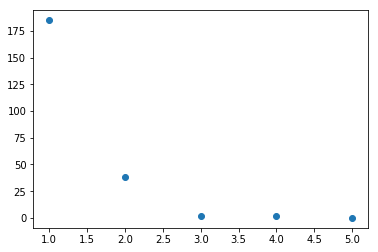

In [129]:
my_leaf_size = 30

X = []
cluster_count_Y = []
results = []
for my_eps in range(1,6):
    clustering = DBSCAN(algorithm='auto', eps=my_eps, leaf_size=my_leaf_size, metric='precomputed').fit(distance_matrix)
    cluster_count = clustering.labels_.max()
    X.append(my_eps)
    cluster_count_Y.append(cluster_count)
    results.append([my_eps,cluster_count])
    
plt.scatter(X,cluster_count_Y)

In [128]:
print(results)

[[1, 185], [2, 38], [3, 2], [4, 2], [5, 0]]


In [44]:
my_leaf_size = 30

results = []
X = []
Y = []
Z = []
for my_eps in range(1,4):
    for my_leaf_size in range(10,50):
        clustering = DBSCAN(algorithm='auto', eps=my_eps, leaf_size=my_leaf_size, metric='precomputed').fit(distance_matrix)
        X.append(my_leaf_size)
        Y.append(my_eps)
        Z.append(clustering.labels_.max())
        results.append([my_leaf_size, my_eps, clustering.labels_.max()])


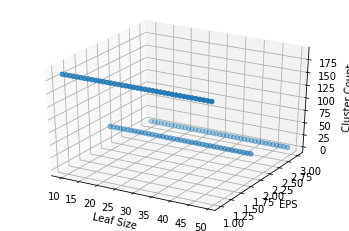

In [46]:
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.set_xlabel('Leaf Size')
ax.set_ylabel('EPS')
ax.set_zlabel('Cluster Count')

ax.scatter(X, Y, Z)

#plt.contour3D(results)

It looks like the number of clusters doesn't change when we modify the leaf_size. The 2D and 3D diagrams appear to be very similar, when taking a slice along the x-axis/z-axis plane.

### Prediction
Now, let's take a look at predicting the cluster for new data.

In [49]:
my_leaf_size = 30
my_eps = 1
clustering = DBSCAN(algorithm='auto', eps=my_eps, leaf_size=my_leaf_size, metric='precomputed').fit_predict(distance_matrix)

In [78]:
#new_ngram_as_urls = [['/', '/', '/', '/', '/images/ksclogosmall.gif']]
#new_ngram = n_gram_list_to_ids(new_ngram_as_urls)[0]
i = 20
new_ngram = sample_n_gram_list_as_ids[i]
my_eps = 1

def predict(new_data, cluster, eps, metric, training_data):
    matching_clusters = []
    closest_cluster = -1
    for i in range (0, len(cluster)):
        distance = metric(new_data,training_data[i])
        if (distance <= eps):
            matching_clusters.append(clustering[i])
    return set(matching_clusters)    
    
print(predict(new_ngram, clustering, my_eps, get_levenshtein_distance, sample_n_gram_list_as_ids), clustering[i])


{1, 109, -1} -1


### Thoughts so far
This experiment as to see if I could predict which cluster a new piece of data would fall into. I think I have the mechanics down. However, I think I've made some non-optimal choices for the clustering parameters. 

The updates to this experiment would be to dig deeper into the resulting clustering to ensure the parameters are more optimal and then look at how the prediction funtion performs.

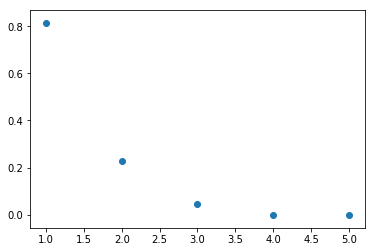

In [130]:
my_eps = 4
my_leaf_size = 30
results = []
X = []
percent_outliers_Y = []
for my_eps in range(1,6):
    clusters = DBSCAN(algorithm='auto', eps=my_eps, leaf_size=my_leaf_size, metric='precomputed').fit_predict(distance_matrix)
    #print(clusters.max())
    #sns.distplot(clusters, rug=True)
    percent_outliers = np.count_nonzero(clusters == -1)/len(clusters)
    X.append(my_eps)
    percent_outliers_Y.append(percent_outliers)
    results.append([my_eps,percent_outliers])
plt.scatter(X,percent_outliers_Y)

In [133]:
print("Percent Outliers ", percent_outliers_Y)
print("Cluster Count ", cluster_count_Y)

Percent Outliers  [0.8120536364961376, 0.22722635184375456, 0.04394403148229121, 7.287567409998542e-05, 0.0]
Cluster Count  [185, 38, 2, 2, 0]


We see that when our distance max is set to 1, more than 80% of the test data is not put into a cluster. If we set our max to 3, then the un-clustered data is down to 4%, but we only have 2 clusters. So while not an amazing result, if we set our max distane to 2, we have 38 clusters and about 23% un-clustered data. This seems to balance out the desire to have meaningful diversity in our clusters and a model that classifies most of our test data.
